In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}

import os
import tempfile
import pint

ureg = pint.UnitRegistry()
os.environ["OPENBLAS_NUM_THREADS"] = "1"

from IPython.display import HTML, display
import h5py
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (5, 4)

import tdgl
from tdgl.geometry import box, circle
from tdgl.visualization.animate import create_animation

c:\Users\jsche\Documents\GitHub\tdgl\.conda\Lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


### Superconductive Film

In [2]:
length_units = "nm"
# Material parameters from Petrovic
xi = 13
london_lambda = 39
d = 25
layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=1)

# Device geometry
total_width = 512
total_length = 512
link_width = total_width / 3
# Outer geometry of the film
film = (
    tdgl.Polygon("film", points=box(total_width, total_length))
    .resample(401)
    .buffer(0)
)

# Current terminals
source = (
    tdgl.Polygon("source", points=box(1.1 * total_width, total_length / 100))
    .translate(dy=total_length / 2)
)
drain = source.scale(yfact=-1).set_name("drain")
#  Voltage measurement points
probe_points = [(0, total_length / 2.5), (0, -total_length / 2.5)]

In [3]:
device = tdgl.Device(
    "small_square", #512x512 nm
    layer=layer,
    film=film,
    terminals=[source,drain],
    probe_points=probe_points,
    length_units=length_units,
)

In [4]:
device_no_terminals = tdgl.Device(
  "small_square",
  layer=layer,
  film=film,
  length_units=length_units
)

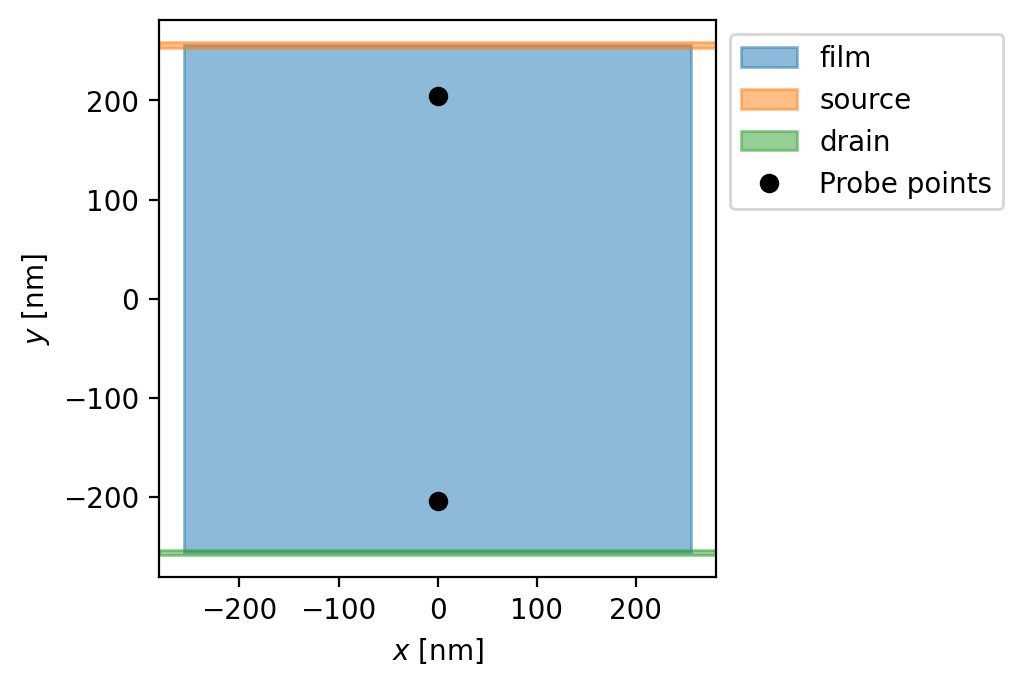

In [5]:
fig, ax = device.draw()

In [6]:
device.make_mesh(max_edge_length=xi / 2, smooth=100)
device_no_terminals.make_mesh(max_edge_length=xi / 2, smooth=100)

Constructing Voronoi polygons:   0%|          | 0/21531 [00:00<?, ?it/s]Malformed Voronoi cell surrounding boundary site 1. Try changing the number of boundary mesh sites using Polygon.resample() or Polygon.buffer(eps) where eps is 0 or a small positive float.
Malformed Voronoi cell surrounding boundary site 2. Try changing the number of boundary mesh sites using Polygon.resample() or Polygon.buffer(eps) where eps is 0 or a small positive float.
Malformed Voronoi cell surrounding boundary site 11. Try changing the number of boundary mesh sites using Polygon.resample() or Polygon.buffer(eps) where eps is 0 or a small positive float.
Malformed Voronoi cell surrounding boundary site 12. Try changing the number of boundary mesh sites using Polygon.resample() or Polygon.buffer(eps) where eps is 0 or a small positive float.
Malformed Voronoi cell surrounding boundary site 14. Try changing the number of boundary mesh sites using Polygon.resample() or Polygon.buffer(eps) where eps is 0 or a sm

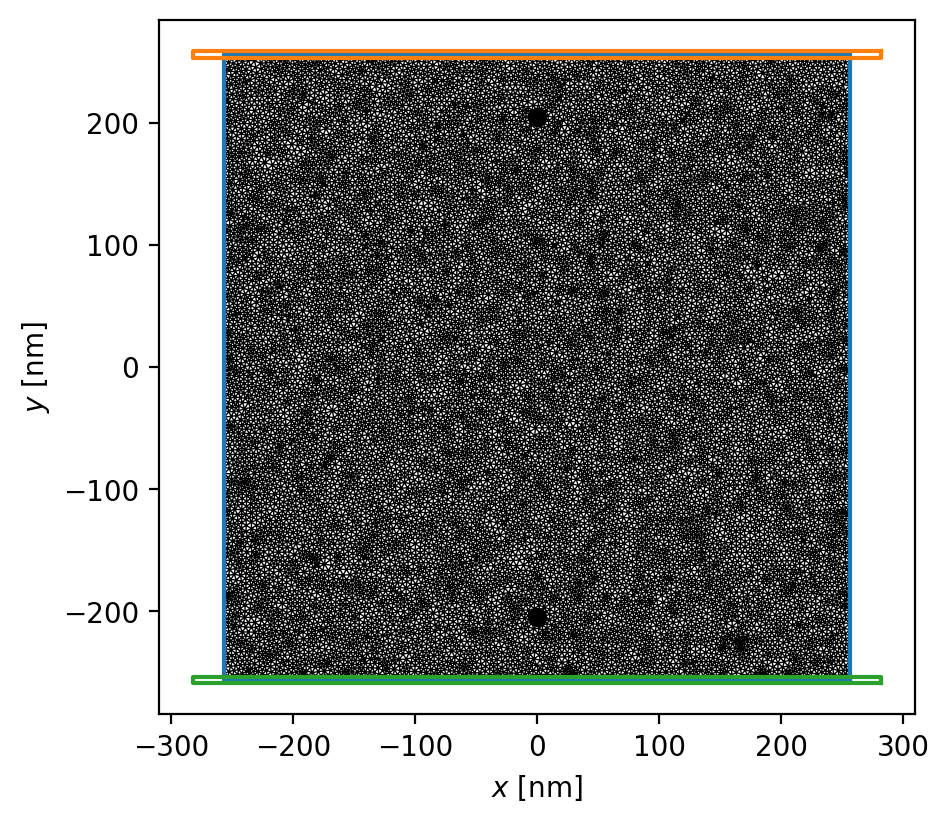

In [7]:
fig, ax = device.plot(mesh=True, legend=False)

In [8]:
device.mesh_stats()

num_sites,21531
num_elements,42602
min_edge_length,1.613e+00
max_edge_length,6.636e+00
mean_edge_length,3.785e+00
min_area,2.277e+00
max_area,2.754e+01
mean_area,1.218e+01
coherence_length,13
length_units,nm


### Example Code

In [9]:
"""
Example code
"""

# import numpy as np

# from ..em import uniform_Bz_vector_potential, ureg
# from ..parameter import Parameter


# def constant_field_vector_potential(
#     x,
#     y,
#     z,
#     *,
#     Bz: float,
#     field_units: str = "mT",
#     length_units: str = "um",
# ):
#     if z.ndim == 0:
#         z = z * np.ones_like(x)
#     positions = np.array([x.squeeze(), y.squeeze(), z.squeeze()]).T
#     positions = (positions * ureg(length_units)).to("m").magnitude
#     Bz = Bz * ureg(field_units)
#     A = uniform_Bz_vector_potential(positions, Bz)
#     return A.to(f"{field_units} * {length_units}").magnitude


# def ConstantField(
#     value: float = 0, field_units: str = "mT", length_units: str = "um"
# ) -> Parameter:
#     """Returns a Parameter that computes a constant as a function of ``x, y, z``.
#     Args:
#         value: The constant value of the field.
#     Returns:
#         A Parameter that returns ``value`` at all ``x, y, z``.
#     """
#     return Parameter(
#         constant_field_vector_potential,
#         Bz=float(value),
#         field_units=field_units,
#         length_units=length_units,
#     )
# def uniform_Bz_vector_potential(
#     positions: np.ndarray,
#     Bz: Union[float, str, pint.Quantity],
# ) -> np.ndarray:
#     """Calculates the magnetic vector potential [Ax, Ay, Az] at ``positions``
#     due uniform magnetic field along the z-axis with strength ``Bz``.

#     Args:
#         positions: Shape (n, 3) array of (x, y, z) positions in meters at which to
#             evaluate the vector potential.
#         Bz: The strength of the uniform field, as a pint-parseable string,
#             a pint.Quantity, or a float with units of Tesla.

#     Returns:
#         Shape (n, 3) array of the vector potential [Ax, Ay, Az] at ``positions``
#         in units of Tesla * meter.
#     """
#     assert isinstance(Bz, (float, str, pint.Quantity)), type(Bz)
#     positions = np.atleast_2d(positions)
#     assert positions.shape[1] == 3, positions.shape
#     if not isinstance(positions, pint.Quantity):
#         positions = positions * ureg("meter")
#     if isinstance(Bz, str):
#         Bz = ureg(Bz)
#     if isinstance(Bz, float):
#         Bz = Bz * ureg("tesla")
#     xs = positions[:, 0]
#     ys = positions[:, 1]
#     dx = np.ptp(xs)
#     dy = np.ptp(ys)
#     xs = xs - (xs.min() + dx / 2)
#     ys = ys - (ys.min() + dy / 2)
#     Ax = -Bz * ys / 2
#     Ay = Bz * xs / 2
#     A = np.stack([Ax, Ay, np.zeros_like(Ax)], axis=1)
#     return A.to("tesla * meter")

#  self.dynamic_vector_potential = (
#             isinstance(applied_vector_potential, Parameter)
#             and applied_vector_potential.time_dependent
#         )
#         if not callable(applied_vector_potential):
#             applied_vector_potential = ConstantField(
#                 applied_vector_potential,
#                 field_units=field_units,
#                 length_units=device.length_units,
#             )
#         self.applied_vector_potential = applied_vector_potential
#         # Evaluate the vector potential
#         self.A_scale = (
#             (ureg(field_units) * length_units / (Bc2 * xi * length_units))
#             .to_base_units()
#             .magnitude
#         )
#         A_kwargs = dict(t=0) if self.dynamic_vector_potential else dict()
#         current_A_applied = self.applied_vector_potential(
#             self.edge_centers[:, 0], self.edge_centers[:, 1], self.z0, **A_kwargs
#         )
#         current_A_applied = self.A_scale * np.asarray(current_A_applied)[:, :2]
#         if current_A_applied.shape != self.edge_centers.shape:
#             raise ValueError(
#                 f"Unexpected shape for vector_potential: {current_A_applied.shape}."
#             )

'\nExample code\n'

### Vector potential calculation

In [10]:
# """
# Vector potential calcuations
# """
# from scipy import interpolate
# from tdgl import Parameter
# CURRENT_DIRECTORY = os.getcwd()
# DATA_AND_LAYER_NAME = "B_demag_125mT_0K_layer2"
# DEMAG_B_Z_FILEPATH = os.path.join(CURRENT_DIRECTORY, "mumax_fields", "%s_z.npy" % DATA_AND_LAYER_NAME)
# DEMAG_B_Z = np.load(DEMAG_B_Z_FILEPATH)
# APPLIED_B_Z = 0.125
# B_Z = DEMAG_B_Z + APPLIED_B_Z
# # B_Z = np.reshape(B_Z, (np.shape(B_Z)[0] * np.shape(B_Z)[1], 1))

# def textured_vector_potential(
#     positions,
#     Bz,
# ):
#     """
#     Calculates the magnetic vector potential [Ax, Ay, Az] at ``positions``
#     due uniform magnetic field along the z-axis with strength ``Bz``.

#     Args:
#     positions: Shape (n, 3) array of (x, y, z) positions in meters at which to
#         evaluate the vector potential.
#     Bz: The strength of the the field with shape (m, m) with units of Tesla, where
#     m is the size of the Mumax simulation

#     Returns:
#     Shape (n, 3) array of the vector potential [Ax, Ay, Az] at ``positions``
#     in units of Tesla * meter.

#     """
#     # assert isinstance(Bz, (float, str, pint.Quantity)), type(Bz)
#     # positions = np.atleast_2d(positions)
#     # assert positions.shape[1] == 3, positions.shape
#     # if not isinstance(positions, pint.Quantity):
#     #     positions = positions * ureg("meter")
#     # if isinstance(Bz, str):
#     #     Bz = ureg(Bz)
#     # if isinstance(Bz, float):
#     #     Bz = Bz * ureg("tesla")


#     # Assuming 'positions' is already defined as in the previous example
#     # Extract the x and y values from the positions array

#     xy_vals = positions[:, :2]
    
#     # Calculate the range (peak-to-peak) of x and y values
#     dx = np.ptp(xy_vals[:, 0])
#     dy = np.ptp(xy_vals[:, 1])
#     # Calculate the center point for x and y
#     center_x = np.min(xy_vals[:, 0]) + dx / 2
#     center_y = np.min(xy_vals[:, 1]) + dy / 2
#     center = np.array([center_x, center_y])
#     # Subtract the center point from all xy values to center the data
#     xy_vals_centered = xy_vals - center
#     centered_xs = xy_vals_centered[:, 0]
#     centered_ys = xy_vals_centered[:, 1]
#     # make a grid equally sized as the positions but with spacings equivalent to the Mumax mesh
#     grid_xs = np.linspace(centered_xs.min(), centered_xs.max(), np.shape(Bz)[0])
#     grid_ys = np.linspace(centered_ys.min(), centered_ys.max(), np.shape(Bz)[1])
#     X,Y = np.meshgrid(grid_xs, grid_ys)
#     Bz_points = np.vstack([X.ravel(), Y.ravel()]).T
    
#     # reshape Bz from 128x128 in Mumax into 128^2 by 2
#     flattened_Bz_values = np.reshape(Bz, (np.shape(Bz)[0] * np.shape(Bz)[1], 1))

#     # interpolate to find Bz at positions
#     interpolated_Bz = interpolate.griddata(Bz_points, flattened_Bz_values, xy_vals_centered)
#     interpolated_Bz = interpolated_Bz*ureg("tesla")
#     centered_ys = centered_ys*ureg("meter")
#     centered_xs = centered_xs*ureg("meter")

#     # x-y component of vector potential
#     Axy = interpolated_Bz * np.stack([centered_ys, -1*centered_ys], axis=1)
    
#     A = np.hstack([Axy, np.zeros_like(Axy[:,:1])])
    
#     A = A.to("tesla * meter")
    
#     return A

# def FM_field_vector_potential(
#     x,
#     y,
#     z,
#     *,
#     field_units: str = "T",
#     length_units: str = "um",
# ):
#     if z.ndim == 0:
#         z = z * np.ones_like(x)
#     positions = np.array([x.squeeze(), y.squeeze(), z.squeeze()]).T
#     positions = (positions * ureg(length_units)).to("m").magnitude
#     Bz = B_Z * ureg(field_units)
#     A = textured_vector_potential(positions, Bz)
#     return A.to(f"{field_units} * {length_units}").magnitude

# def FMField(
#     field_units: str = "T", length_units: str = "um"
# ) -> Parameter:
#     """Returns a Parameter that computes a constant as a function of ``x, y, z``.
#     Args:
#         value: The constant value of the field.
#     Returns:
#         A Parameter that returns ``value`` at all ``x, y, z``.
#     """
#     return Parameter(
#         FM_field_vector_potential,
#         field_units=field_units,
#         length_units=length_units,
#     )


In [17]:
options = tdgl.SolverOptions(
    solve_time=50,
    output_file=os.path.join("tdgl_results", "75mT_nocurrent_50sec_y_field.h5"),
    field_units="T",
    current_units="uA",
)
from fmfield_y import FMField
RAMP_FIELD = True

# if RAMP_FIELD:
#     from tdgl.sources import LinearRamp
#     # Ramp the applied field from 0 to 0.4 mT between t=0 and t=100, then hold it at 0.4 mT.
#     applied_vector_potential = (
#         LinearRamp(tmin=0, tmax=100)
#         * FMField()
#     )
# else:
#     # If applied_vector_potential is given as a single number,
#     # it is interpreted to mean the vector potential associated with a
#     # uniform out-of-plane magnetic field with the specified strength.
#     # This is simply shorthand for
#     # ConstantField(0.4, field_units=options.field_units, length_units=device.length_units).
#     applied_vector_potential = FMField()

mumax_solution = tdgl.solve(
    device_no_terminals,
    options,
    applied_vector_potential=FMField(),
    # terminal_currents=dict(source=1000, drain=-1000)
)


QhullError: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull d Qbb Qc Qz Qt Q12
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2082453501  delaunay  Qbbound-last  Qcoplanar-keep  Qz-infinity-point
  Qtriangulate  Q12-allow-wide  _pre-merge  _zero-centrum  Qinterior-keep
  Pgood  _max-width 0.00051  Error-roundoff 3.6e-19  _one-merge 2.5e-18
  Visible-distance 7.1e-19  U-max-coplanar 7.1e-19  Width-outside 1.4e-18
  _wide-facet 4.3e-18  _maxoutside 2.8e-18

The input to qhull appears to be less than 3 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p16384(v4): 1.3e-23     0 0.00026
- p63(v3): -2e-06     0     0
- p127(v2): 0.00026     0 0.00023
- p0(v1): -0.00026     0 0.00023

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 3.6e-19.  The center point, facets and distances
to the center point are as follows:

center point -5.039e-07        0 0.0001804

facet p63 p127 p0 distance=    0
facet p16384 p127 p0 distance=    0
facet p16384 p63 p0 distance=    0
facet p16384 p63 p127 distance=    0

These points either have a maximum or minimum x-coordinate, or
they maximize the determinant for k coordinates.  Trial points
are first selected from points that maximize a coordinate.

The min and max coordinates for each dimension are:
  0:  -0.000256  0.000256  difference= 0.000512
  1:         0         0  difference=    0
  2:         0  0.000256  difference= 0.000256

If the input should be full dimensional, you have several options that
may determine an initial simplex:
  - use 'QJ'  to joggle the input and make it full dimensional
  - use 'QbB' to scale the points to the unit cube
  - use 'QR0' to randomly rotate the input for different maximum points
  - use 'Qs'  to search all points for the initial simplex
  - use 'En'  to specify a maximum roundoff error less than 3.6e-19.
  - trace execution with 'T3' to see the determinant for each point.

If the input is lower dimensional:
  - use 'QJ' to joggle the input and make it full dimensional
  - use 'Qbk:0Bk:0' to delete coordinate k from the input.  You should
    pick the coordinate with the least range.  The hull will have the
    correct topology.
  - determine the flat containing the points, rotate the points
    into a coordinate plane, and delete the other coordinates.
  - add one or more points to make the input full dimensional.


### FM Solution

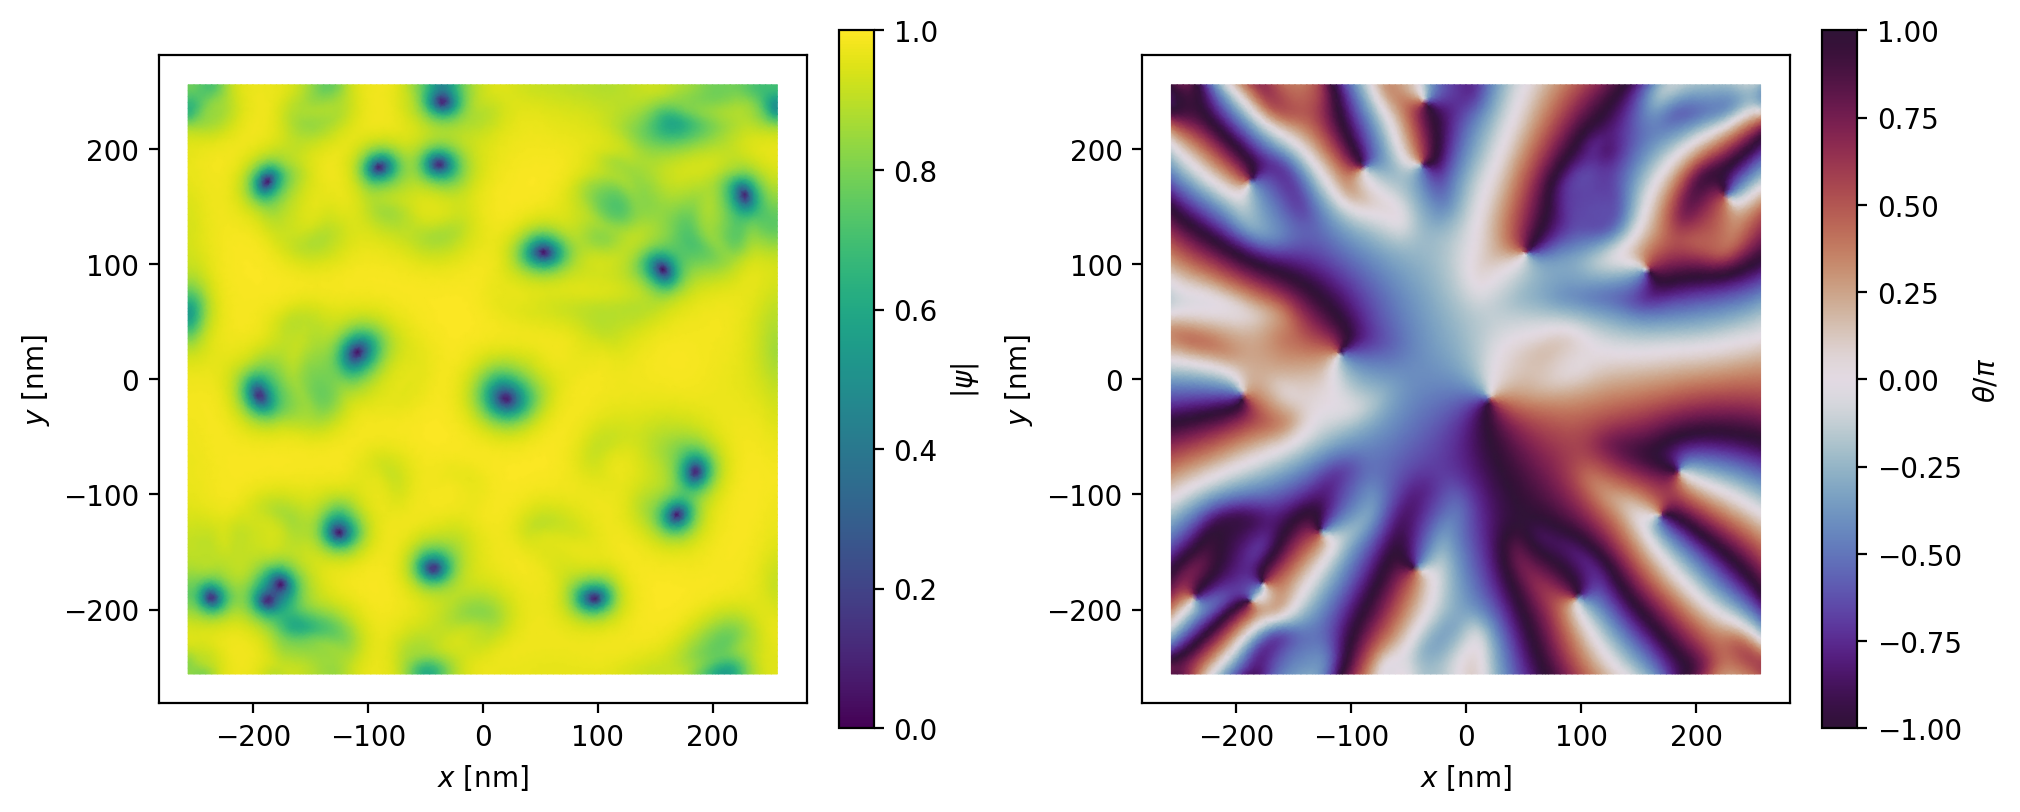

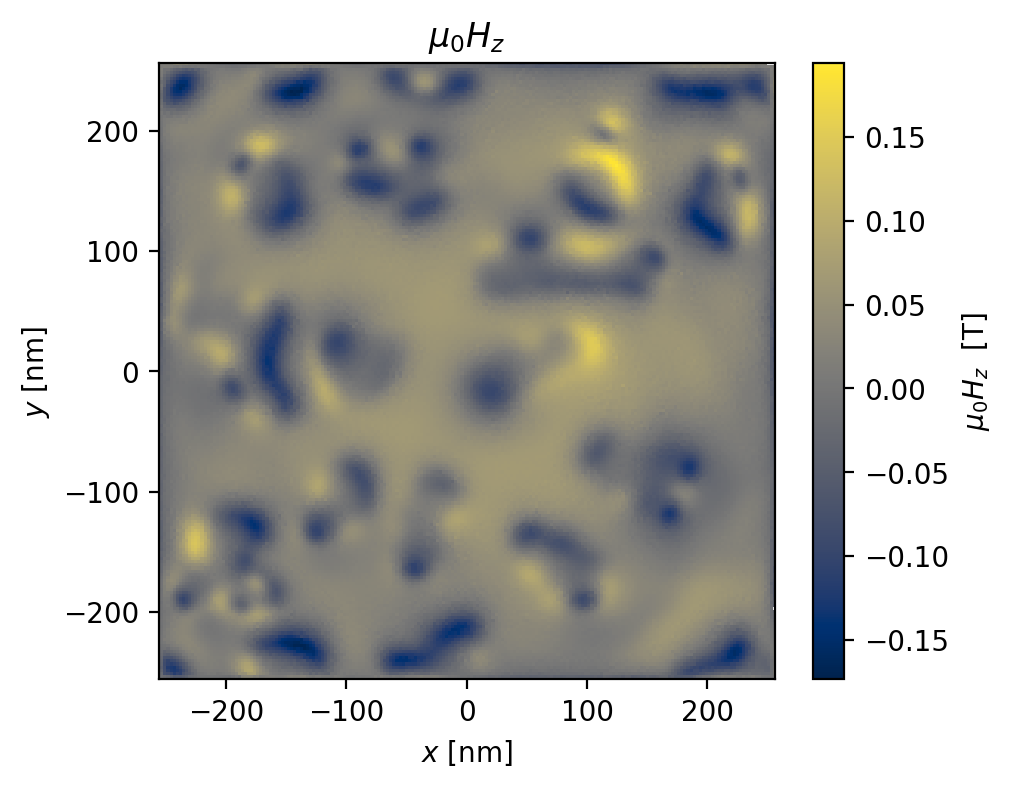

In [14]:
mumax_solution = tdgl.Solution.from_hdf5(r"C:\Users\jsche\Documents\GitHub\tdgl\tdgl_results\75mT_nocurrent_400sec_corner_origin.h5")
fig, axes   = mumax_solution.plot_order_parameter(figsize=(10, 4))
edge_centers = xi * device_no_terminals.mesh.edge_mesh.centers
x = edge_centers[:,0]
y = edge_centers[:,1]
z0 = (device.layer.z0+1) * np.ones(len(edge_centers), dtype=float)
positions = np.array([x.squeeze(), y.squeeze(), z0.squeeze()]).T
fig,axes = mumax_solution.plot_field_at_positions(positions)


In [ ]:
print(np.shape(device.mesh.edge_mesh.edges))
print(np.shape(device.mesh.sites))


(64132, 2)
(21531, 2)


More example code below for run

In [ ]:
# # options = tdgl.SolverOptions(
# #     solve_time=200,
# #     output_file=os.path.join("tdgl_results", "skyrmions_please.h5"),
# #     field_units="T",
# #     current_units="uA",
# # )

# # RAMP_FIELD = True

# # if RAMP_FIELD:
# #     from tdgl.sources import LinearRamp, ConstantField

# #     # Ramp the applied field from 0 to 0.4 mT between t=0 and t=100, then hold it at 0.4 mT.
# #     applied_vector_potential = (
# #         LinearRamp(tmin=0, tmax=100)
# #         * ConstantField(25, field_units=options.field_units, length_units=device.length_units)
# #     )
# # else:
# #     # If applied_vector_potential is given as a single number,
# #     # it is interpreted to mean the vector potential associated with a
# #     # uniform out-of-plane magnetic field with the specified strength.
# #     # This is simply shorthand for
# #     # ConstantField(0.4, field_units=options.field_units, length_units=device.length_units).
# #     applied_vector_potential = 25

# field_current_solution = tdgl.solve(
#     device,
#     options,
#     applied_vector_potential=.125,
#     terminal_currents=dict(source=12, drain=-12),
#     The seed solution will be used as the initial state of the film.
# )

Output file already exists. Renaming to tdgl_results\skyrmions_please-3.h5.
Simulating:  16%|█▌        | 32/200 [00:52<04:33,  1.63s/tau ]


In [ ]:
def make_video_from_solution(
    solution,
    quantities=("order_parameter", "phase"),
    fps=20,
    figsize=(5, 4),
):
    """Generates an HTML5 video from a tdgl.Solution."""
    with tdgl.non_gui_backend():
        with h5py.File(solution.path, "r") as h5file:
            anim = create_animation(
                h5file,
                quantities=quantities,
                fps=fps,
                figure_kwargs=dict(figsize=figsize),
            )
            video = anim.to_html5_video()
        return HTML(video)

In [ ]:
MAKE_ANIMATIONS=True
if MAKE_ANIMATIONS:
    mumax_FM_field_video = make_video_from_solution(
        mumax_solution,
        quantities=["order_parameter", "phase", "scalar_potential"],
        figsize=(6.5, 4),
    )
    display(mumax_FM_field_video)